In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [3]:
data = 'data'

train_data, test_data = tf.keras.utils.audio_dataset_from_directory(
    directory = data,
    validation_split = 0.2,
    batch_size = 64,
    seed = 42,
    subset = 'both',
    output_sequence_length = 16000
)

label_names = np.array(train_data.class_names)
print(label_names)

Found 7705 files belonging to 8 classes.
Using 6164 files for training.
Using 1541 files for validation.
['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [4]:
def squeeze(audio,labels):
    audio = tf.squeeze(audio,axis=-1)
    return audio, labels

In [5]:
train_data = train_data.map(squeeze,tf.data.AUTOTUNE)
test_data = test_data.map(squeeze,tf.data.AUTOTUNE)

In [6]:
validating = test_data.shard(num_shards=2,index=0)
testing = test_data.shard(num_shards=2,index=1)


In [7]:
def spectogram(waveform):
    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectogram = tf.abs(spectogram)
    spectogram = spectogram[...,tf.newaxis]
    return spectogram

In [8]:
def make_dataset(dataset):
    return dataset.map(
        map_func = lambda audio, labels : (spectogram(audio),labels),
        num_parallel_calls = tf.data.AUTOTUNE
    )

In [9]:
training = make_dataset(train_data)
testing = make_dataset(testing)
validating = make_dataset(validating)

In [11]:
training = training.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
testing = testing.cache().prefetch(tf.data.AUTOTUNE)
validating = validating.cache().prefetch(tf.data.AUTOTUNE)

In [12]:
norm_layers = layers.Normalization()
norm_layers.adapt(data = training.map(map_func = lambda spec, labels:spec))

In [13]:
for example_spec, example_Label in training.take(1):
    break

input_shape = example_spec.shape[1:]
print(input_shape)

(124, 129, 1)


In [14]:
num_labels = len(label_names)
print(num_labels)

8


In [16]:
model = models.Sequential([
    layers.Input(input_shape),
    layers.Resizing(32,32),
    norm_layers,
    layers.Conv2D(32,3,activation='relu'),
    layers.Conv2D(64,3,activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.35),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [21]:
history = model.fit(
    training,
    validation_data = validating,
    epochs = 10,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2)
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.2815 - loss: 1.9464 - val_accuracy: 0.5511 - val_loss: 1.3907
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5306 - loss: 1.3411 - val_accuracy: 0.6481 - val_loss: 1.0241
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6609 - loss: 0.9742 - val_accuracy: 0.6986 - val_loss: 0.8478
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7332 - loss: 0.7521 - val_accuracy: 0.7555 - val_loss: 0.7254
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7605 - loss: 0.6605 - val_accuracy: 0.7995 - val_loss: 0.6495
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8002 - loss: 0.5723 - val_accuracy: 0.8072 - val_loss: 0.6230
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8312 - loss: 0.4942 - val_accuracy: 0.8215 - val_loss: 0.5748
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8506 - loss: 0.4423 - val_accuracy: 0.8111 - v

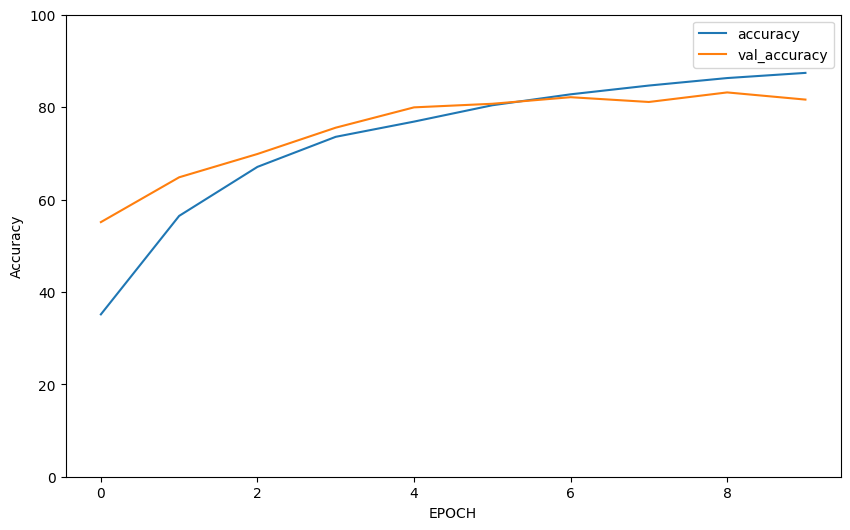

In [23]:
metrics = history.history

plt.figure(figsize = (10,6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy','val_accuracy'])
plt.ylim(0,100)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.show()

In [24]:
results = model.evaluate(testing,return_dict=True)
results = results['accuracy']
print(results)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8456 - loss: 0.5765
0.8359375


In [28]:
counter = 1

for i, (spectogram,labels) in enumerate(testing):
    pred = model.predict(spectogram)
    pred_labels_idx = tf.argmax(pred,axis=1).numpy()
    original_label = label_names[labels.numpy()]
    pred_label = [label_names[idx]for idx in pred_labels_idx]

    for j, label in enumerate(original_label):
        print(f"{counter}, Original Label: {label}, Prediction Label: {pred_label[j]}")
        counter+=1

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1, Original Label: go, Prediction Label: go
2, Original Label: stop, Prediction Label: stop
3, Original Label: stop, Prediction Label: stop
4, Original Label: right, Prediction Label: right
5, Original Label: no, Prediction Label: no
6, Original Label: up, Prediction Label: up
7, Original Label: stop, Prediction Label: stop
8, Original Label: go, Prediction Label: go
9, Original Label: up, Prediction Label: up
10, Original Label: no, Prediction Label: no
11, Original Label: left, Prediction Label: left
12, Original Label: yes, Prediction Label: down
13, Original Label: stop, Prediction Label: stop
14, Original Label: yes, Prediction Label: yes
15, Original Label: no, Prediction Label: no
16, Original Label: stop, Prediction Label: go
17, Original Label: go, Prediction Label: go
18, Original Label: yes, Prediction Label: yes
19, Original Label: no, Prediction Label: down
20, Original Label: down, Prediction Label: down
21, Original Label: yes, Predi